In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the CSV file
star_data = pd.read_csv("/Users/kobibrown/Desktop/Distance_Ladder_Project/star_data_with_temp_and_dist.csv")

# Constants
wavelengths = np.array([440e-9, 500e-9, 700e-9])  # Wavelengths for blue, green, and red bands in meters
flux_cols = ["BlueF", "GreenF", "RedF"]
fluxes = star_data[flux_cols].values
parallax = star_data["Parallax"].values
temperatures = star_data["Temperature"].values

# Calculate the total flux (W/m^2) for each star
total_fluxes = np.sum(fluxes, axis=1)

# Choose the distance calculation method
use_parallax_only = False

# Calculate the distance (m) based on the given conditions
if use_parallax_only:
    distances = np.where(parallax > 0.005, 1 / parallax, np.nan)  # Convert parallax to parsecs
    distances_m = distances * 3.086e16  # Convert parsecs to meters
else:
    distances = np.where(parallax > 0, 1 / parallax, np.nan)  # Convert parallax to parsecs
    distances_m = np.where(distances <= 200, distances * 3.086e16, star_data["Distance"] * 3.086e16)  # Convert parsecs to meters

# Calculate the luminosity (W) using the total flux and distance
luminosities = 4 * np.pi**2 * distances_m**2 * total_fluxes

# Calculate the radii (m) using the Stefan-Boltzmann law
sigma = 5.670374419e-8  # Stefan-Boltzmann constant in W/m^2/K^4
radii = np.sqrt(luminosities / (4 * (np.pi) * sigma * temperatures**4))

# Calculate the uncertainties
flux_uncertainty = np.sqrt(
    star_data["BlueF_Uncertainty"]**2 +
    star_data["GreenF_Uncertainty"]**2 +
    star_data["RedF_Uncertainty"]**2
)
distance_uncertainty = star_data["Distance Uncertainty"] * 3.086e16

dLuminosity_dDistance_m = 8 * np.pi * distances_m * total_fluxes
dLuminosity_dTotal_flux = 4 * np.pi * distances_m ** 2

luminosity_uncertainty = np.sqrt(
    (dLuminosity_dDistance_m * distance_uncertainty)**2 +
    (dLuminosity_dTotal_flux * flux_uncertainty)**2
)

dRadii_dLuminosity = 1 / (8 * np.pi * sigma * temperatures**4 * np.sqrt(luminosities))
dRadii_dTemperature = -4 * radii / temperatures

radii_uncertainty = np.sqrt(
    (dRadii_dLuminosity * luminosity_uncertainty)**2 +
    (dRadii_dTemperature * star_data["Temperature_Uncertainty"])**2
)

# Add the new columns to the DataFrame
star_data["Luminosity"] = luminosities
star_data["Luminosity_Uncertainty"] = luminosity_uncertainty
star_data["Radii"] = radii
star_data["Radii_Uncertainty"] = radii_uncertainty

# Export the DataFrame to a new CSV file
star_data.to_csv("/Users/kobibrown/Desktop/Distance_Ladder_Project/star_data_with_luminosity_radii_and_uncertainties.csv", index=False)


/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_31736/374225593.py:26: RuntimeWarning: divide by zero encountered in true_divide
  distances = np.where(parallax > 0, 1 / parallax, np.nan)  # Convert parallax to parsecs


In [111]:
# Create a boolean mask for valid data (non-NaN values)
valid_data_mask = ~np.isnan(radii) & ~np.isnan(luminosities)

# Apply the boolean mask to the arrays
radii_no_nan = radii[valid_data_mask]
luminosity_no_nan = luminosities[valid_data_mask]
radii_uncertainty_no_nan = radii_uncertainty[valid_data_mask]
luminosity_uncertainty_no_nan = luminosity_uncertainty[valid_data_mask]

if radii_no_nan.size > 0:
    # Calculate the 90th percentile of radii_no_nan
    upper_threshold = np.percentile(radii_no_nan, 100)

    # Create a boolean mask for filtering based on the upper threshold
    filter_mask = radii_no_nan <= upper_threshold

    # Filter the radii, luminosity, and their uncertainties based on the filter_mask
    radii_filtered = radii_no_nan[filter_mask]
    luminosity_filtered = luminosity_no_nan[filter_mask]
    radii_uncertainty_filtered = radii_uncertainty_no_nan[filter_mask]
    luminosity_uncertainty_filtered = luminosity_uncertainty_no_nan[filter_mask]

    # Print summary statistics for the filtered radii and luminosity
    print("Summary Statistics for Filtered Star Radii:")
    print(f"Mean: {np.mean(radii_filtered):.2f} m ± {np.mean(radii_uncertainty_filtered):.2f} m")
    print(f"Median: {np.median(radii_filtered):.2f} m")
    print(f"Standard Deviation: {np.std(radii_filtered):.2f} m")
    print(f"Minimum: {np.min(radii_filtered):.2f} m")
    print(f"Maximum: {np.max(radii_filtered):.2f} m")
    print(f"Total Stars: {len(radii_filtered)}")
    print(f"Stars Omitted as Outliers: {len(radii_no_nan) - len(radii_filtered)}")

    print("\nSummary Statistics for Filtered Star Luminosity:")
    print(f"Mean: {np.mean(luminosity_filtered):.2e} W ± {np.mean(luminosity_uncertainty_filtered):.2e} W")
    print(f"Median: {np.median(luminosity_filtered):.2e} W")
    print(f"Standard Deviation: {np.std(luminosity_filtered):.2e} W")
    print(f"Minimum: {np.min(luminosity_filtered):.2e} W")
    print(f"Maximum: {np.max(luminosity_filtered):.2e} W")
    print(f"Total Stars: {len(luminosity_filtered)}")
else:
    print("No valid radii found for the given parallax threshold.")


Summary Statistics for Filtered Star Radii:
Mean: 1632956263.25 m ± 65429320.35 m
Median: 180312776.02 m
Standard Deviation: 7323036512.98 m
Minimum: 132768.07 m
Maximum: 638484837150.87 m
Total Stars: 95814
Stars Omitted as Outliers: 0

Summary Statistics for Filtered Star Luminosity:
Mean: 1.67e+29 W ± 7.56e+27 W
Median: 5.95e+25 W
Standard Deviation: 1.13e+30 W
Minimum: 7.51e+19 W
Maximum: 9.69e+31 W
Total Stars: 95814


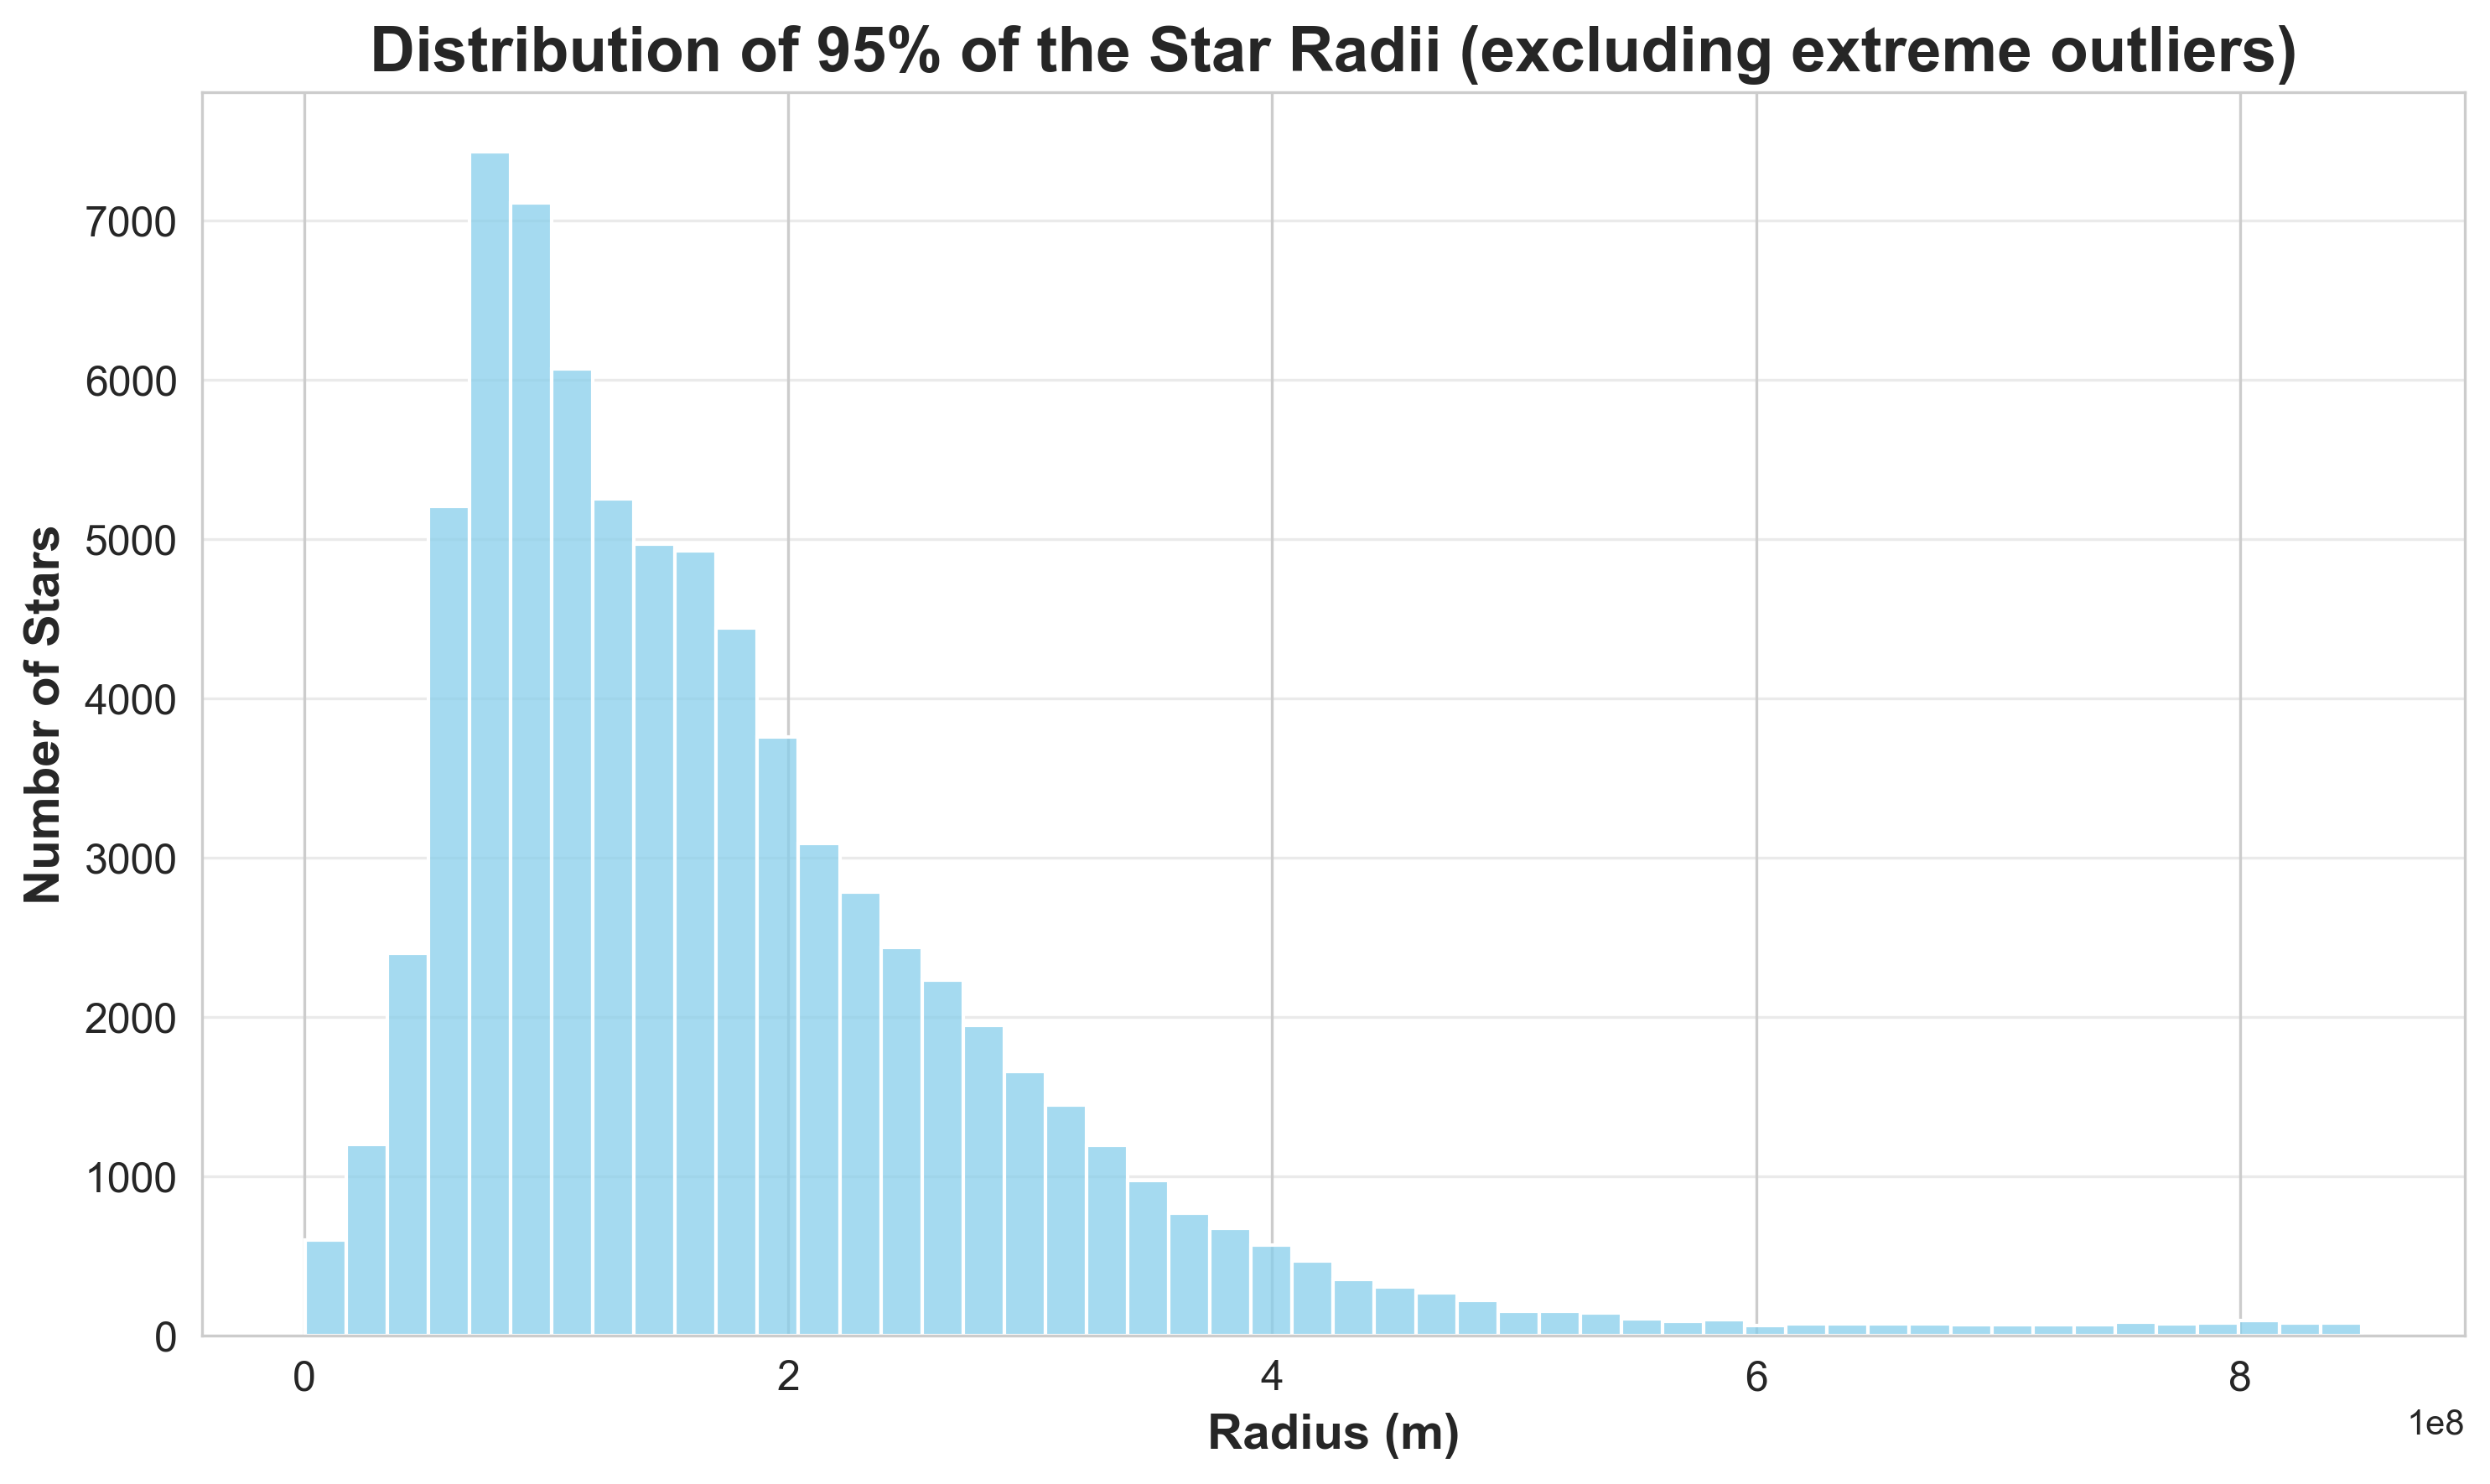

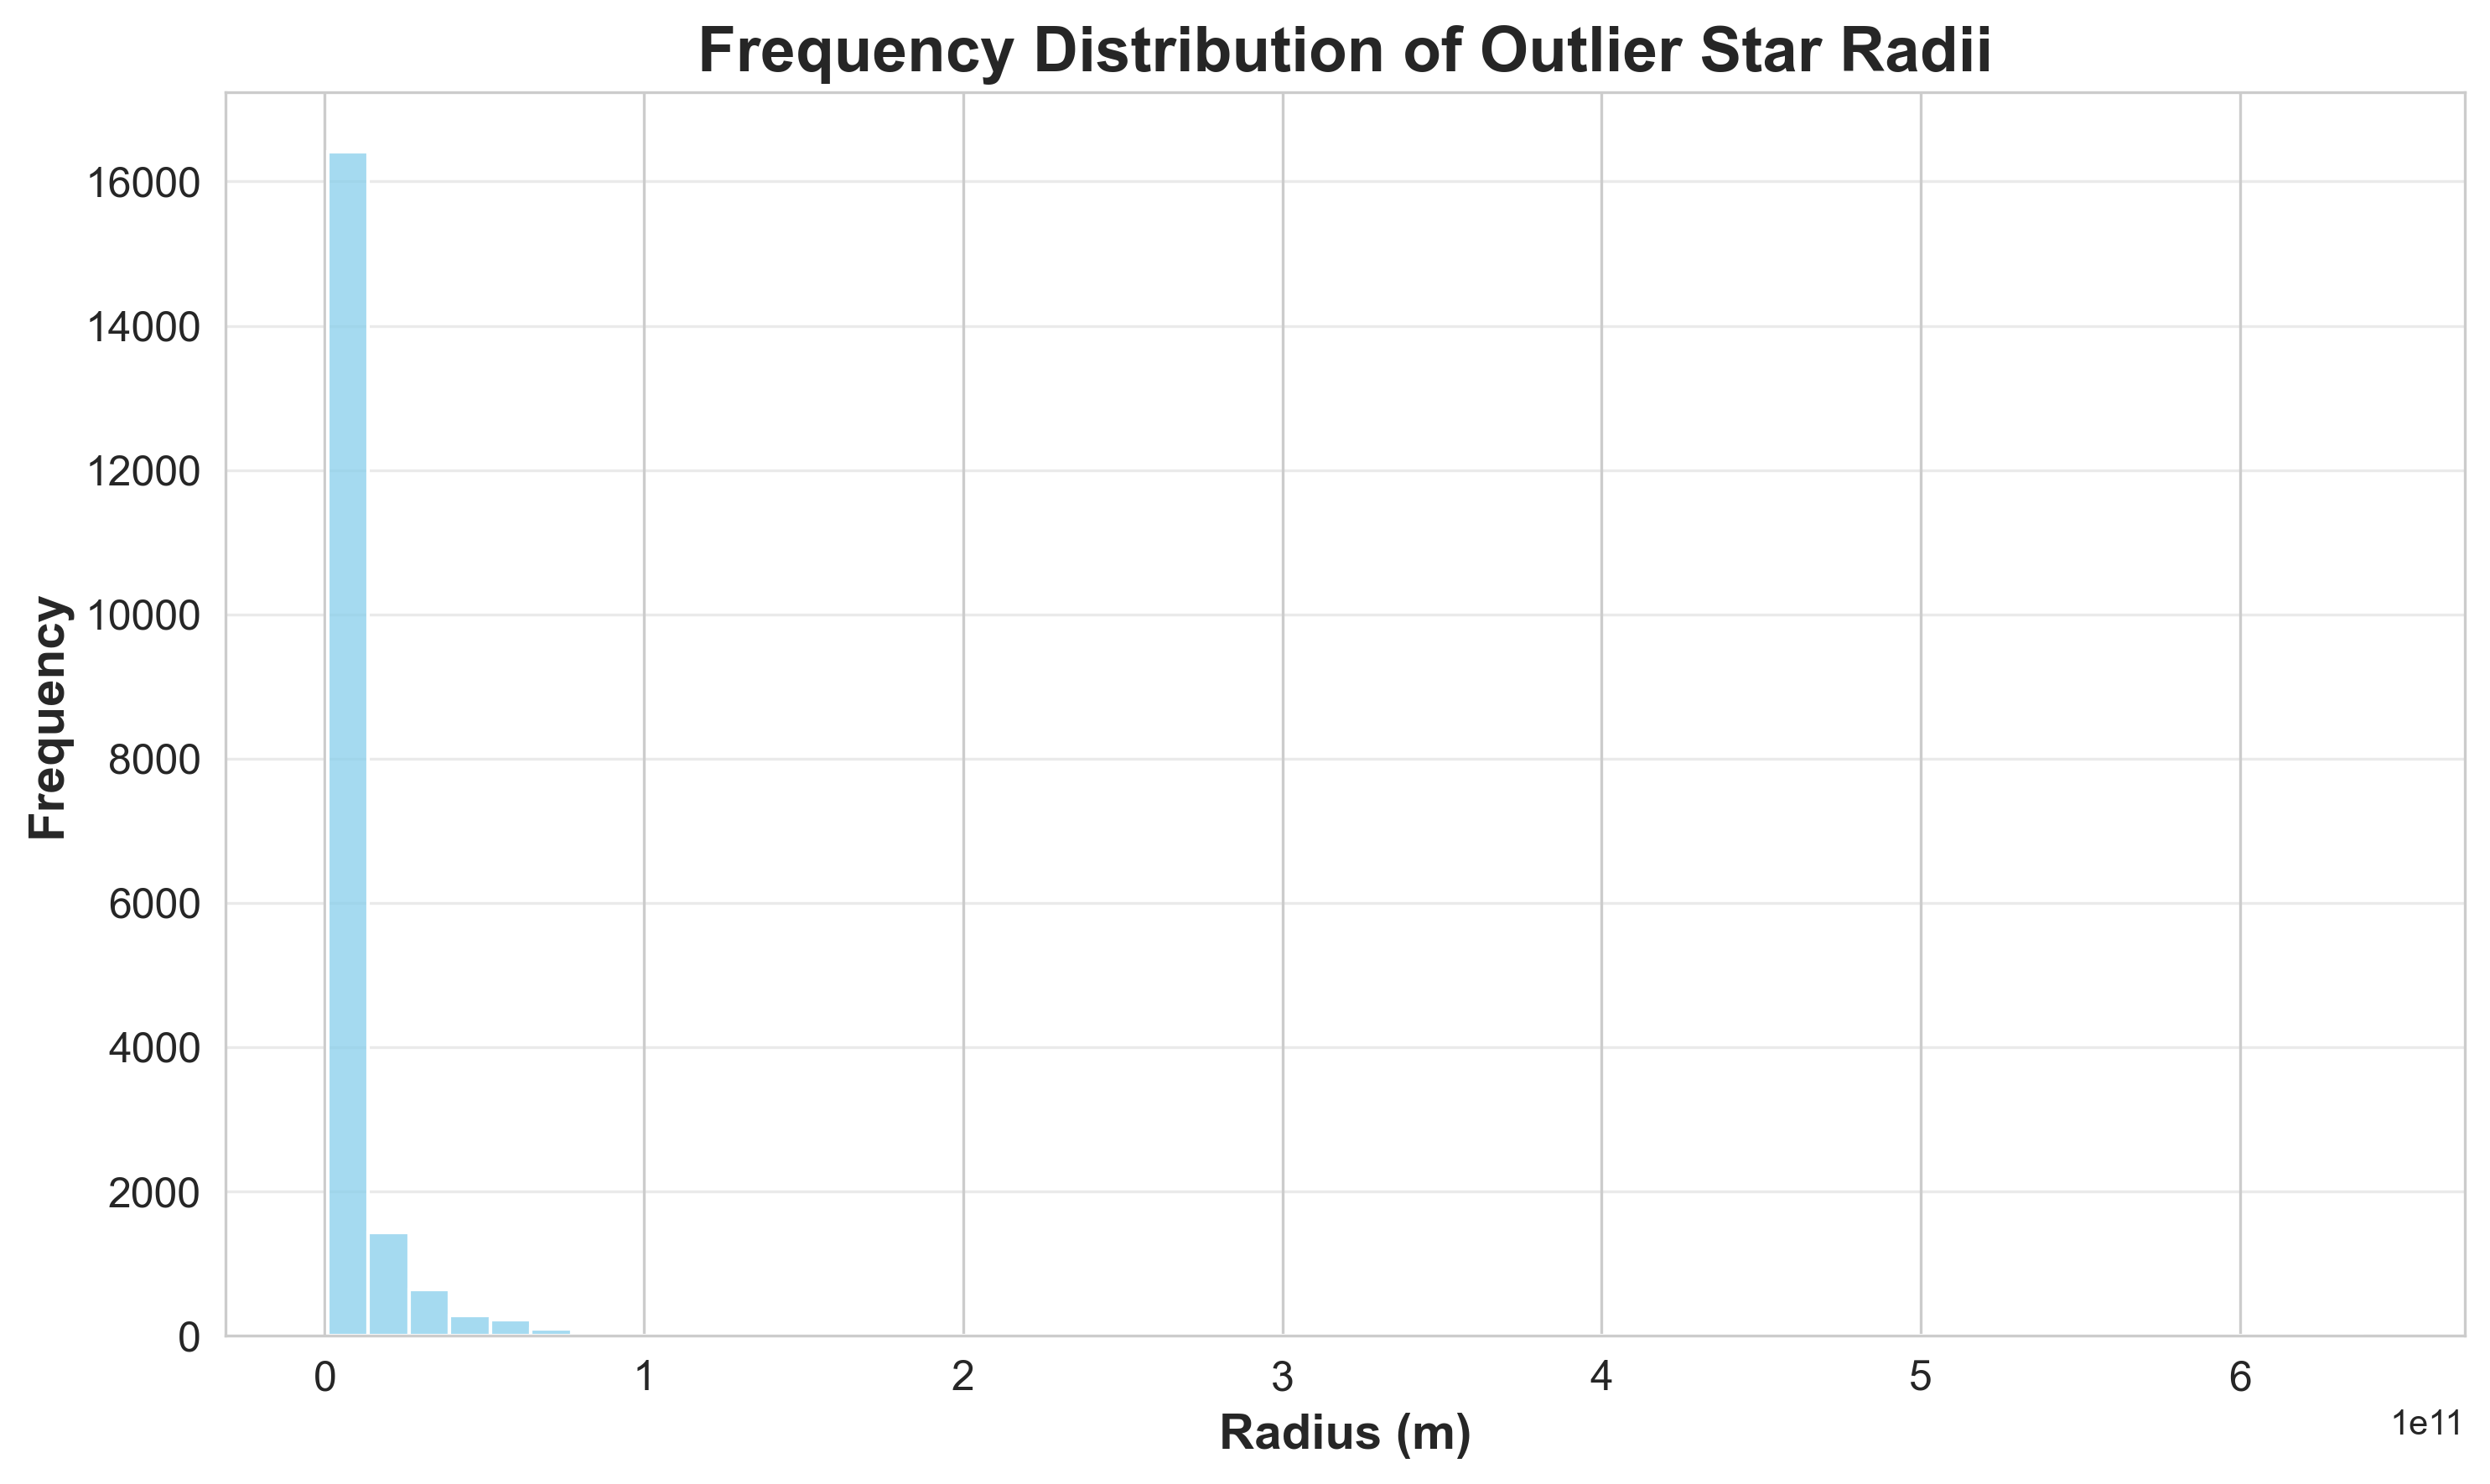

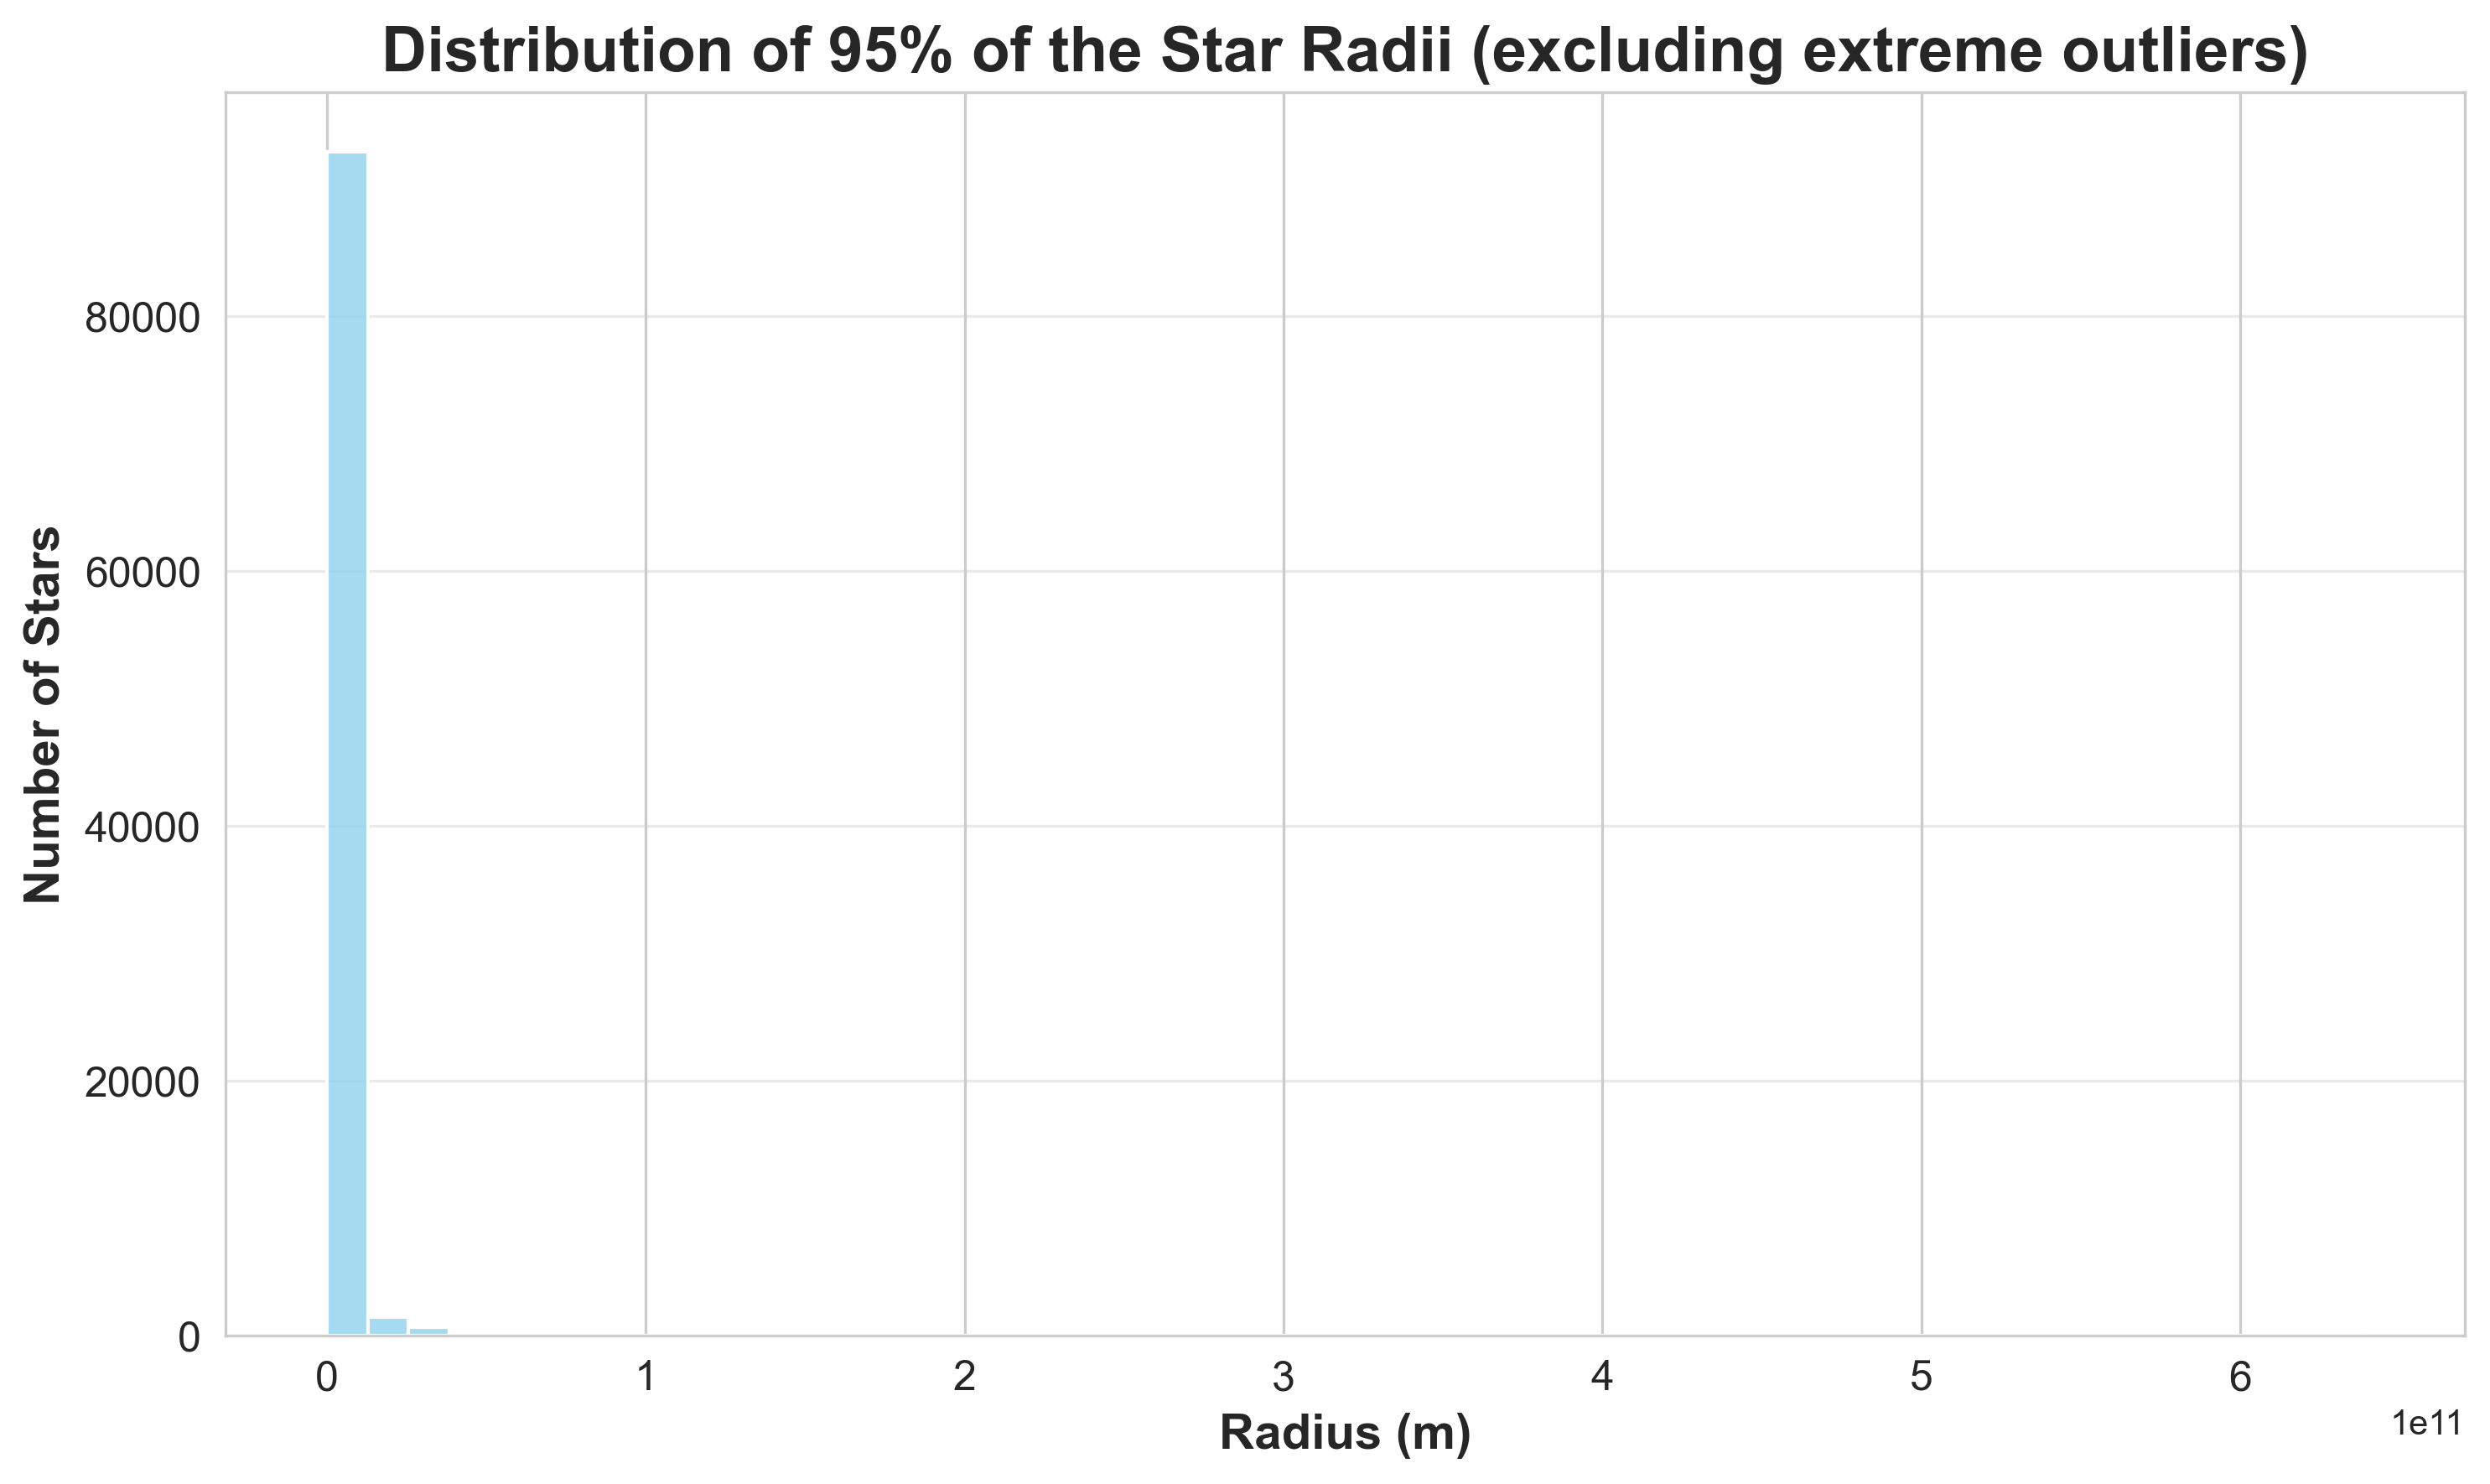

In [110]:
import seaborn as sns

# Create a histogram of the filtered star radii
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

# Plot the histogram with 50 bins
ax = sns.histplot(x=radii_filtered, bins=50, color="skyblue", kde=False)

# Set title and axis labels
ax.set_title("Distribution of 95% of the Star Radii (excluding extreme outliers)", fontsize=18, fontweight="bold")
ax.set_xlabel("Radius (m)", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Stars", fontsize=14, fontweight="bold")

# Set tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)

# Add grid lines and legend
ax.grid(axis="y", alpha=0.4)

# Save and show the plot
plt.tight_layout()
plt.savefig("filtered_star_radii.png")
plt.show()

# Create a histogram of the outlier star radii
outlier_radii = radii_no_nan[radii_no_nan > upper_threshold]

plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

# Plot the histogram with 50 bins
ax = sns.histplot(x=outlier_radii, bins=50, color="skyblue", kde=False)

# Set title and axis labels
ax.set_title("Frequency Distribution of Outlier Star Radii", fontsize=18, fontweight="bold")
ax.set_xlabel("Radius (m)", fontsize=14, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=14, fontweight="bold")

# Set tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)

# Add grid lines and legend
ax.grid(axis="y", alpha=0.4)

# Save and show the plot
plt.tight_layout()
plt.savefig("outlier_star_radii.png")
plt.show()

# Create a histogram of all the star radii
plt.figure(figsize=(10, 6), dpi=300)
sns.set_style("whitegrid")

# Plot the histogram with 50 bins
ax = sns.histplot(x=radii_no_nan, bins=50, color="skyblue", kde=False)

# Set title and axis labels
ax.set_title("Distribution of 95% of the Star Radii (excluding extreme outliers)", fontsize=18, fontweight="bold")
ax.set_xlabel("Radius (m)", fontsize=14, fontweight="bold")
ax.set_ylabel("Number of Stars", fontsize=14, fontweight="bold")

# Set tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)

# Add grid lines and legend
ax.grid(axis="y", alpha=0.4)

# Save and show the plot
plt.tight_layout()
plt.savefig("all_star_radii.png")
plt.show()
